In [3]:
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
import math
import time
import cv2
from numba import jit,njit, float32
from numpy import *
from itertools import product
import copy
from json import load

In [4]:
def multivariate_normall(x, mu1, cov1, mu2, cov2):
    size = len(x)
    pdf_1=(math.log(1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(np.linalg.det(cov1),1.0/2))))+(-0.5 * ((x - mu1).dot(np.linalg.inv(cov1)).dot((x - mu1).T)))
    pdf_2=(math.log(1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(np.linalg.det(cov2),1.0/2))))+(-0.5 * ((x - mu2).dot(np.linalg.inv(cov2)).dot((x - mu2).T)))
    return pdf_1, pdf_2

def find_neighbors_coord(i, j, dim1, dim2):
    neighbors = []
    for row_step in (-1, 0, 1):
        for col_step in (-1, 0, 1):
            if row_step * col_step == 0 and col_step != row_step:
                if i + row_step == -1 or j + col_step == -1:
                    continue
                if i + row_step >= dim1 or j + col_step >= dim2:
                    continue
                neighbors.append((i + row_step, j + col_step))

    return neighbors

def define_arcs_structure(matrix, eps, shape):
    new_matrix = empty(shape=shape[:2], dtype=object)
    for i in range(shape[0]):
        for j in range(shape[1]):
            new_matrix[i, j] = {}
            neighbors = find_neighbors_coord(i, j, *shape[:2])
            for n_idx in neighbors:
                new_matrix[i, j][n_idx] = {}
                for k_current, k_neigh in product((0, 1), repeat=2):
                    new_matrix[i,j][n_idx][(k_current, k_neigh)] = (
                                    (log(eps) if k_current != k_neigh else log(1-eps))
                                    +(matrix[i,j,k_current])/(len(neighbors))
                                    +(matrix[n_idx[0], n_idx[1]][k_neigh])/(len(find_neighbors_coord( n_idx[0], n_idx[1], *shape[:2])))
                    )
                    
    return new_matrix

def remove_low_arcs(matrix, eps):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            pair_dict = matrix[i][j]
            for neighbor in pair_dict.keys():
                max_arc_per_neighbor = max(pair_dict[neighbor].values())
                pair_dict_copy = pair_dict[neighbor].copy()
                for key, arc in pair_dict_copy.items():
                    if arc < (max_arc_per_neighbor - eps):
                        pair_dict[neighbor].pop(key, 0)
    return matrix

def diffusion(structure, shape, iterations):
    for it in range(iterations):
        for i in range(shape[0]):
            for j in range(shape[1]):
                neighbors_arcs = [dict(list(structure[i][j][t].items())) for t in structure[i][j]]
                class1 = [list(neighbors_arcs[l].items())[:2] for l in range(len(neighbors_arcs))]
                class2 = [list(neighbors_arcs[l].items())[2:] for l in range(len(neighbors_arcs))]
                max_g1 = [max([class1[m][k][1] for k in range(2)]) for m in range(len(class1))]
                mean_max_g1 = mean(max_g1)
                max_g2 = [max([class2[m][k][1] for k in range(2)]) for m in range(len(class2))]
                mean_max_g2 = mean(max_g2)
                up_c1 = [[list(neighbors_arcs[t].items())[m][1] - max_g1[t] + mean_max_g1 for m in range(2)] for t in
                         range(len(neighbors_arcs))]
                up_c2 = [[list(neighbors_arcs[t].items())[m][1] - max_g2[t] + mean_max_g2 for m in range(2, 4)] for t in
                         range(len(neighbors_arcs))]
                update_arcs = concatenate([up_c1, up_c2], axis=1)
                count = 0
                c_n = find_neighbors_coord(i, j, shape[0], shape[1])
                for p in range(len(neighbors_arcs)):
                    for n, m in product((0, 1), repeat=2):
                        structure[i][j][c_n[p]][(n, m)] = update_arcs[p][count]
                        structure[c_n[p][0], c_n[p][1]][(i,j)][(m, n)] = update_arcs[p][count]
                        count += 1
                    count = 0
    return structure

def find_markup(structure, shape):
    flag = 0
    for i, j in ndindex((shape[0], shape[1])):
        neighbors = []
        arcs = []
        c_n = find_neighbors_coord(i, j, shape[0], shape[1])
        for n in range(len(c_n)):
            neighbors.append(list(structure[i][j].items())[n][0])
            arcs.append(list(structure[i][j].items())[n][1])
        arcs_copy = copy.deepcopy(arcs)
        for a in range(len(arcs_copy)):
            false_count = 0
            structure_copy = copy.deepcopy(structure[neighbors[a]][(i, j)])
            for arc_classes in arcs_copy[a].keys():
                tmp = arc_classes[::-1]
                if tmp in list(structure_copy.keys()):
                    for n in c_n:
                        count = 0
                        if n != neighbors[a]:
                            first_arcs_idx = [list(structure[i][j][n].keys())[k][0] for k in
                                              range(len(structure[i][j][n].keys()))]
                            if arc_classes[0] not in first_arcs_idx:
                                count += 1
                                structure[i][j][neighbors[a]].pop(arc_classes, 0)
                                flag = 1
                                if count == len(arcs_copy[a]):
                                    print("confusion: markup doesn't exist")
                                    return 0, flag
                    continue
                else:
                    false_count += 1
                    structure[i][j][neighbors[a]].pop(arc_classes, 0)
                    flag = 1
                    if false_count == len(arcs_copy[a]):
                        print("markup doesn't exist")
                        return 0, flag
    return 1, flag

def cut_superfluous_arcs(eps, marked_image_data):
    print(f'eps= {eps}')
    markup_exists = 1
    update_exisis = 1
    matrix_copy1 = copy.deepcopy(marked_image_data)
    remove_low_arcs(matrix_copy1, eps)
    while markup_exists != 0 and update_exisis!=0:
        markup_exists, update_exisis = find_markup(matrix_copy1, shape)
        print(markup_exists, update_exisis)
    return markup_exists, matrix_copy1

def find_max_eps(matrix):
    max_arc = -1000
    min_arc = 1000
    for i, j in ndindex(matrix.shape[:2]):
        for k in list(matrix[i, j].values()):
            max_arc = max(max_arc, (max(list(k.values()))))
            min_arc = min(min_arc, (min(list(k.values()))))
    return max_arc - min_arc

def mark_final_image(matrix):
    final_marks = empty(shape=matrix.shape[:2], dtype=float)
    for i, j in ndindex(matrix.shape[:2]):
        for neighbor, classes in matrix[i][j].items():
            final_marks[i, j] = list(classes.keys())[0][0]
            final_marks[neighbor] = list(classes.keys())[0][1]
    return final_marks

eps= 1002.7823623536696
1 0


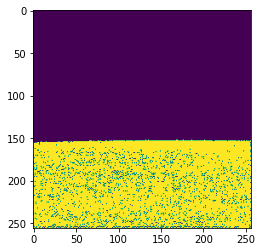

eps= 334.26078745122317
1 0


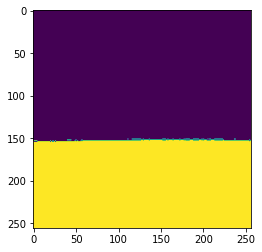

eps= 111.42026248374106
1 0


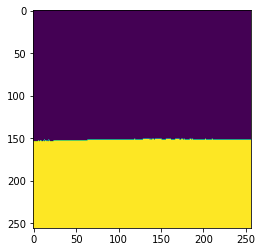

eps= 37.14008749458035
1 0


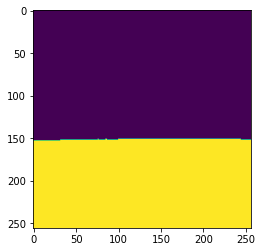

eps= 12.380029164860117
1 0


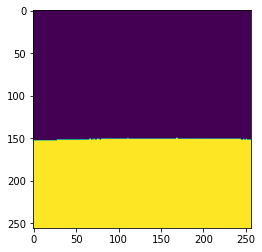

eps= 4.126676388286706
1 0


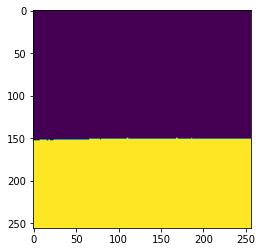

eps= 1.3755587960955686
1 1
1 1
1 0


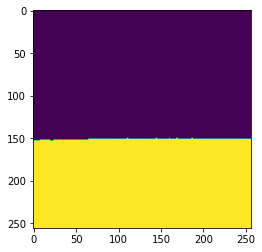

eps= 0.4585195986985229
1 0


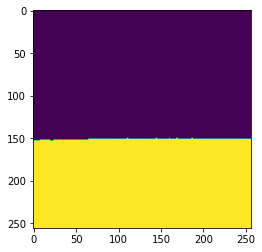

eps= 0.15283986623284096
1 0


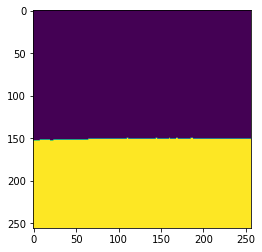

eps= 0.050946622077613656
1 0


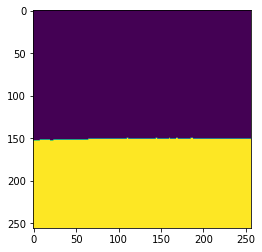

In [5]:
image_path = 'D:/Labs KPI/Labs Pattern/lab1/stock-photo-golden-wheat-field-blue-clear.jpg'
image = Image.open(image_path)
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))
img = asarray(image)
shape = img.shape
image_1 = img[:40, :40]
image_2 = img[230:, 230:]
image_1_conc = concatenate((image_1), axis = 0)
image_1_conc_cov = cov(image_1_conc, rowvar=False)
image_2_conc = concatenate((image_2), axis = 0)
image_2_conc_cov = cov(image_2_conc, rowvar=False)
step = 3
marked_image_data  = zeros(shape=(*(shape)[:2], 2) , dtype=float)
for i in range(shape[0]):
        for j in range(shape[1]):
            marked_image_data[i][j] = multivariate_normall(img[i][j], image_1_conc.mean(axis = 0), image_1_conc_cov, image_2_conc.mean(axis = 0), image_2_conc_cov)
marked_image_data = define_arcs_structure(marked_image_data, 0.2, shape)       
marked_image_data = diffusion(marked_image_data, shape, 2)
eps = find_max_eps(marked_image_data)
while eps-eps/step>0.1:
    markup_exists, matrix_copy1 = cut_superfluous_arcs(eps/step, marked_image_data)
    try:
        if markup_exists == 0:
            matrix_copy1 = matrix_copy2   
            final_marks = mark_final_image(matrix_copy1)    
            plt.imshow(final_marks)
            plt.show()
            break
    except:
        print('step should be less')
        step = step*0.8
        continue
    else:
        matrix_copy2 = copy.deepcopy(matrix_copy1)

    eps = eps/step
    final_marks = mark_final_image(matrix_copy1)    
    plt.imshow(final_marks)
    plt.show()
#print(f'time:  {time.process_time() - t}')